## EE4540 - Distributed Signal Processing - Course Project
Nishita Anand, Rubhav Nayak

##
### Question 1:

Design a proper connected sensor network that covers the area of the plant by using a
reasonable number of sensors. How many do we need to guarantee a connected sensor
network? Motivate your choice.

In [2]:
# This is done by using a Random Geometric Graph
#Reference:
# 1. https://academic.oup.com/book/9064?login=true
# 2. https://arxiv.org/pdf/1207.2573: formulation for the radius

#https://dl.acm.org/doi/pdf/10.1145/958491.958496

In [3]:
# Import Libraries

from numpy import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time

In [4]:
# Essential Functions

# Function to calculate adjacency matrix
def calculate_adjacency_matrix(agent_locations, communication_range):
    num_agents = agent_locations.shape[1]
    adjacency_matrix = np.zeros((num_agents, num_agents), dtype=int)

    for i in range(num_agents):
        for j in range(num_agents):
            if i != j:  # to avoid self-loops
                distance = np.linalg.norm(agent_locations[:, i] - agent_locations[:, j])
                if distance <= communication_range:
                    adjacency_matrix[i, j] = 1

    return adjacency_matrix

# Function to check graph connectivity
def is_graph_connected(adjacency_matrix):
    degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
    laplacian_matrix = degree_matrix - adjacency_matrix
    eigenvalues = np.linalg.eigvalsh(laplacian_matrix)
    zero_eigenvalues = np.sum(np.isclose(eigenvalues, 0))
    return zero_eigenvalues == 1

# Function to create transition matrix P
def generate_uniform_P(adjacency_matrix):
    n = adjacency_matrix.shape[0]
    P = np.zeros((n, n), dtype=float)

    for i in range(n):
        neighbors = np.where(adjacency_matrix[i] == 1)[0]
        degree = len(neighbors)
        if degree > 0:
            P[i, neighbors] = 1.0 / degree  # Uniform distribution over neighbors
        # If no neighbors, row stays all zero (won't be used anyway)

    return P


Is network connected? True


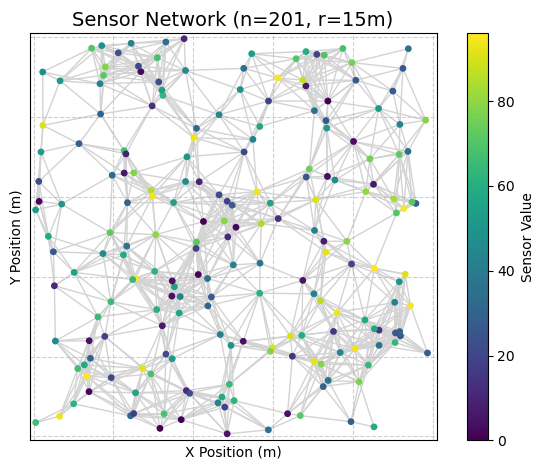

In [5]:
# Generate Distributed Sensor Network

# Parameters
n = 201
area_size = 100
r = 15

# Generate sensor locations as [2, n] array
np.random.seed(50)
positions = np.random.uniform(0, area_size, (n, 2)).T 

# Calculate adjacency matrix and check connectivity
adj_matrix = calculate_adjacency_matrix(positions, r)
connected = is_graph_connected(adj_matrix)

# Print result
print(f"Is network connected? {connected}")

# Make the network in networkx for PDMM and plotting
G = nx.from_numpy_array(adj_matrix)
pos_dict = {i: positions[:, i] for i in range(n)}


# Generating values for each node/sensor
np.random.seed(50) # Constant seed for reproducibility
sensor_values=np.random.randint(0, 100, (n, 1))
colors = sensor_values.flatten()

# Draw nodes first
nodes = nx.draw_networkx_nodes(
    G,
    pos=pos_dict,
    node_size=15,
    node_color=colors,
    cmap=plt.cm.viridis,
)

# Draw edges separately
nx.draw_networkx_edges(
    G,
    pos=pos_dict,
    edge_color='lightgray'
)

plt.title(f"Sensor Network (n={n}, r={r}m)", fontsize=14)
plt.xlim(-1, 101)
plt.ylim(-1, 101)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box')

# Now add colorbar based on nodes
plt.colorbar(nodes, label="Sensor Value")

plt.tight_layout()
plt.show()

##
### Question 2

Suppose the sensor network would like to compute the average value of the
measurement data. In addition to a randomised gossip implementation, which will
serve as a baseline method, implement the average consensus problem using the
PDMM algorithm. Report the performance in terms of convergence speed and number
of transmissions and compare this to the results obtained by the randomised gossip
algorithm.

###
Part 1: Randomized Gossip

In [8]:
def randomized_gossip_average_consensus(
    adj_matrix,
    sensor_values,
    iters=500000,
    epsilon=1e-27,
    p_fail=0.0,
    seed=50,
    verbose=True,
    trueAvg=0
):

    if seed is not None:
        np.random.seed(seed)

    n = len(sensor_values)
    sensor_values_rg = sensor_values.copy().astype(float)

    if trueAvg == 0:
      avg = np.mean(sensor_values_rg)
    else:
      avg = trueAvg

    avg_vec = avg * np.ones(n)
    error_rg = []

    t_start = time.perf_counter()

    for step in range(iters):
        i = np.random.randint(0, n)  # pick random node

        neighbors = []
        for k in range(n):
            if adj_matrix[i, k] == 1:
                neighbors.append(k)

        if len(neighbors) == 0:
            continue

        j = neighbors[np.random.randint(0, len(neighbors))]

        # Update only if transmission succeeds
        if np.random.rand() > p_fail:
            x_ij_avg = 0.5 * (sensor_values_rg[i] + sensor_values_rg[j])
            sensor_values_rg[i] = x_ij_avg
            sensor_values_rg[j] = x_ij_avg


        diff = sensor_values_rg - avg_vec
        squared_error = np.mean(diff**2)
        error_rg.append(squared_error)

        if squared_error < epsilon:
            t_end = time.perf_counter()
            elapsed = t_end - t_start
            if verbose:
                print(f"Stopped at step {step+1} with error {squared_error:.2e}")
                print(f"Elapsed time: {elapsed:.4f} seconds")
            return error_rg, elapsed

    t_end = time.perf_counter()
    elapsed = t_end - t_start
    if verbose:
        print(f"Ran full {iters} steps. Final error: {squared_error:.2e}")
        print(f"Elapsed time: {elapsed:.4f} seconds")
    return error_rg, elapsed


Stopped at step 286654 with error 1.00e-27
Elapsed time: 31.5720 seconds


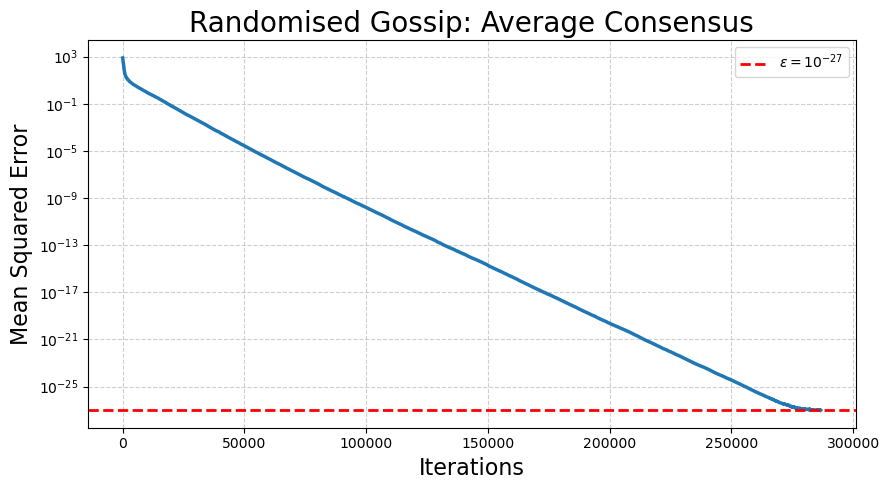

In [9]:
# Run Randomized Gossip on Sensor Data
error_rg, elapsed = randomized_gossip_average_consensus(adj_matrix, sensor_values)

plt.figure(figsize=(9,5))
plt.semilogy(error_rg, lw=2.5, alpha=1)
plt.axhline(1e-27, color='red', linestyle='--', linewidth=2,
            label=r'$\epsilon = 10^{-27}$')
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Mean Squared Error", fontsize=16)
plt.title("Randomised Gossip: Average Consensus", fontsize=20)
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

###
Part 2: Average Consensus using PDMM

In [10]:
def pdmm_average_consensus(
    adj_matrix,
    sensor_values,
    c=0.256,
    iters=1000,
    p_fail=0.0,
    seed=None,
    verbose=True,
    trueAvg=0
):
    if seed is not None:
        np.random.seed(seed)

    n = len(sensor_values)
    sensor_values_pdmm_avg = sensor_values.copy().astype(float)

    if trueAvg == 0:
      true_average = np.mean(sensor_values_pdmm_avg)
    else:
      true_average = trueAvg

    x = sensor_values_pdmm_avg.astype(float).copy()
    z = {}
    for i in range(n):
        for j in range(n):
            if adj_matrix[i, j] == 1:
                z[(i, j)] = 0.0

    x_history = [x.copy()]
    error_ac = [np.mean((x - true_average)**2)]

    t_start = time.perf_counter()

    for k in range(iters):
        x_new = x.copy()

        trans_success = {}
        for i in range(n):
            for j in range(n):
                if adj_matrix[i, j] == 1:
                    trans_success[(i, j)] = np.random.rand() > p_fail

        for i in range(n):
            neighbors = [j for j in range(n) if adj_matrix[i, j] == 1 and trans_success[(i, j)]]
            d = len(neighbors)
            if d > 0:
                sum_z = sum(z[(i, j)] for j in neighbors)
                x_new[i] = (sensor_values_pdmm_avg[i] - sum_z) / (1 + c * d)

        y = {}
        for i in range(n):
            for j in range(n):
                if adj_matrix[i, j] == 1 and trans_success[(i, j)]:
                    y[(i, j)] = z[(i, j)] + 2 * c * x_new[i]

        for i in range(n):
            for j in range(n):
                if adj_matrix[i, j] == 1:
                    if trans_success[(i, j)] and trans_success.get((j, i), False):
                        z[(j, i)] = -y[(i, j)]

        x = x_new.copy()
        x_history.append(x.copy())
        error_ac.append(np.mean((x - true_average)**2))

        # Early stop condition
        if error_ac[-1] < 1e-27:
            if verbose:
                print(f"Stopped early at iteration {k+1} with error {error_ac[-1]:.2e}")
            break

    t_end = time.perf_counter()
    elapsed = t_end - t_start
    if verbose:
        print(f"Elapsed time: {elapsed:.4f} seconds")

    return x_history, error_ac, elapsed


Stopped early at iteration 212 with error 7.36e-28
Elapsed time: 8.7745 seconds


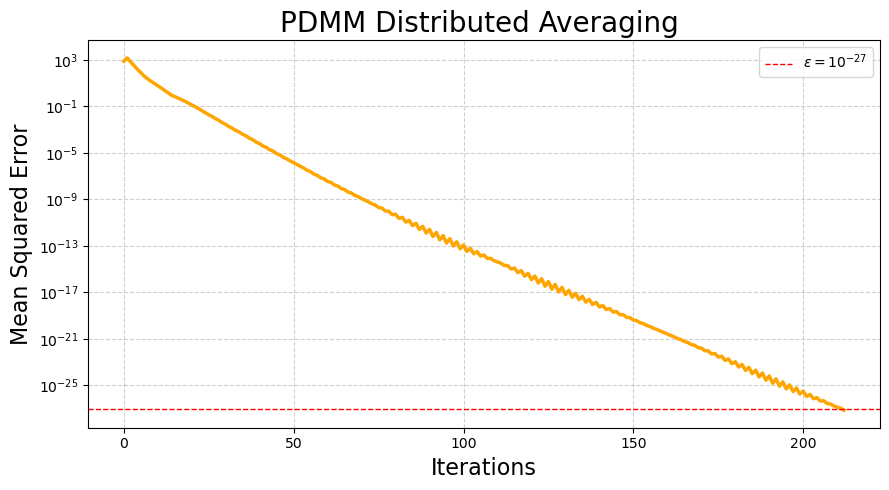

Final error: 7.36e-28
Elapsed time: 8.7745 seconds


In [11]:
# Plot PDMM Average Consensus Results

x_history, error_ac, elapsed = pdmm_average_consensus(adj_matrix, sensor_values, c=0.4, iters=2000, seed=50)

plt.figure(figsize=(9,5))
plt.semilogy(error_ac, color='orange',lw=2.5, alpha=1)
plt.axhline(1e-27, color='red', linestyle='--', linewidth=1,
            label=r'$\epsilon = 10^{-27}$')
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Mean Squared Error", fontsize=16)
plt.title("PDMM Distributed Averaging ", fontsize=20)
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Final error: {error_ac[-1]:.2e}")
print(f"Elapsed time: {elapsed:.4f} seconds")


##
### Question 3

Suppose the sensor network would like to compute the median of the measurement
data. Implement the median consensus problem using the PDMM algorithm.

###
Median Consensus Using PDMM

In [12]:
def pdmm_median_consensus(
    adj_matrix,
    sensor_values,
    c=0.1,
    iters=20000,
    p_fail=0.0,
    seed=None,
    verbose=True,
    trueMed=0
):

    if seed is not None:
        np.random.seed(seed)

    G = nx.from_numpy_array(adj_matrix)
    n = len(sensor_values)
    neighbors = {i: list(G.neighbors(i)) for i in G.nodes()}
    degrees = np.array([len(neighbors[i]) for i in range(n)])

    s = sensor_values.flatten()
    if trueMed == 0:
      true_med = np.median(s)
    else:
      true_med = trueMed

    # Initialization
    x = s.astype(float).copy()
    z = {(i, j): 0.0 for i in G for j in neighbors[i]}
    error_mc = []

    t_start = time.perf_counter()

    for k in range(iters):
        x_new = np.zeros_like(x)

        # Transmission mask per edge
        trans_success = {(i, j): (np.random.rand() > p_fail) for i in G for j in neighbors[i]}

        # Primal update
        for i in range(n):
            di = degrees[i]
            if di == 0:
                x_new[i] = s[i]
                continue

            sum_z = sum(
                (1 if i < j else -1) * z[(i, j)]
                for j in neighbors[i]
                if trans_success[(i, j)]
            )

            di_eff = sum(trans_success[(i, j)] for j in neighbors[i])
            if di_eff == 0:
                x_new[i] = x[i]
                continue

            bound_1 = (1 - sum_z) / (c * di_eff)
            bound_2 = (-1 - sum_z) / (c * di_eff)

            lower_bound = min(bound_1, bound_2)
            upper_bound = max(bound_1, bound_2)

            if s[i] < lower_bound:
                x_new[i] = lower_bound
            elif s[i] > upper_bound:
                x_new[i] = upper_bound
            else:
                x_new[i] = s[i]

        # Dual update
        old_z = z.copy()
        for i in range(n):
            for j in neighbors[i]:
                if trans_success[(i, j)] and trans_success.get((j, i), False):
                    A_ij = 1 if i < j else -1
                    z[(j, i)] = 0.5 * old_z[(j, i)] + 0.5 * (old_z[(i, j)] + 2 * c * A_ij * x_new[i])

        x = x_new
        error_mc.append(np.mean((x - true_med) ** 2))

        # Early stopping condition
        if error_mc[-1] < 1e-27:
            if verbose:
                print(f"Stopped early at iteration {k+1} with error {error_mc[-1]:.2e}")
            break

    t_end = time.perf_counter()
    elapsed = t_end - t_start
    if verbose:
        print(f"Elapsed time: {elapsed:.4f} seconds")
    return x, error_mc, elapsed


Stopped early at iteration 11276 with error 2.94e-28
Elapsed time: 68.8050 seconds


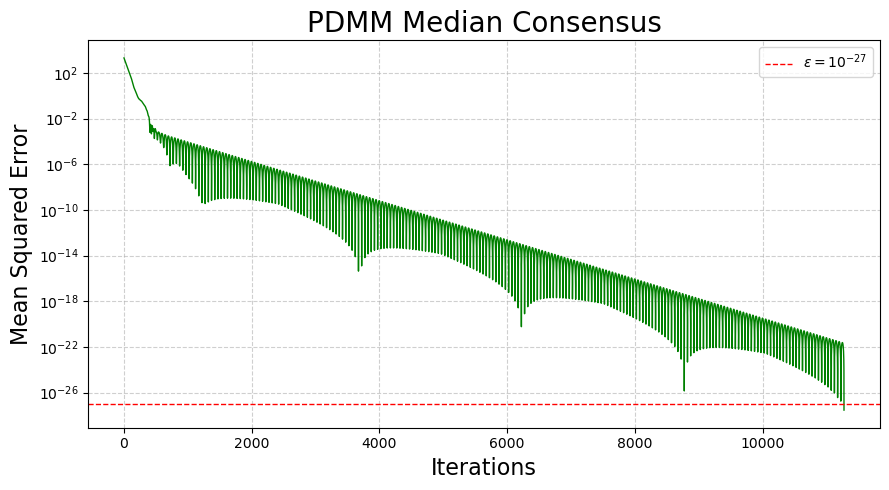

Final error: 2.94e-28
Elapsed time: 68.8050 seconds


In [13]:
# Plot Median Consensus

x_history, error_mc, elapsed = pdmm_median_consensus(adj_matrix, sensor_values, c=0.1, iters=20000, seed=50)


plt.figure(figsize=(9,5))
plt.semilogy(error_mc, color='green',lw=1, alpha=1)
plt.axhline(1e-27, color='red', linestyle='--', linewidth=1,
            label=r'$\epsilon = 10^{-27}$')
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Mean Squared Error", fontsize=16)
plt.title("PDMM Median Consensus", fontsize=20)
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Final error: {error_mc[-1]:.2e}")
print(f"Elapsed time: {elapsed:.4f} seconds")

##
### Additional Graphs/Metrics

###
A. Sensor Failure

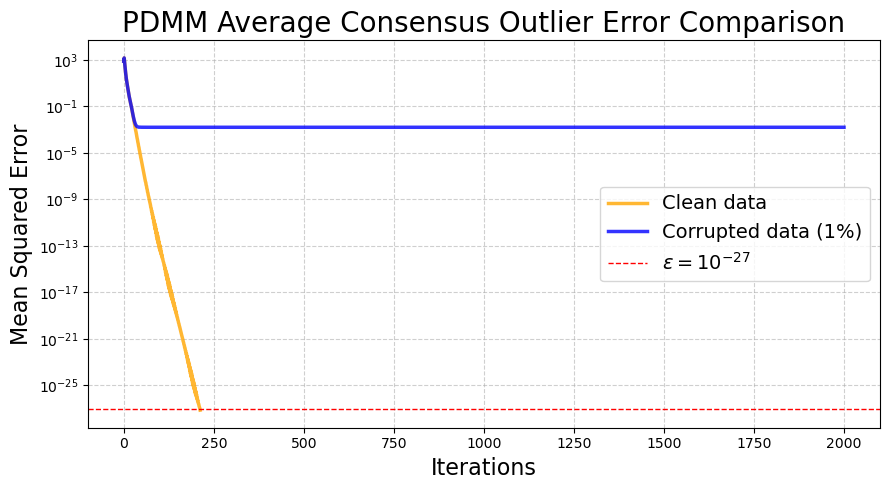

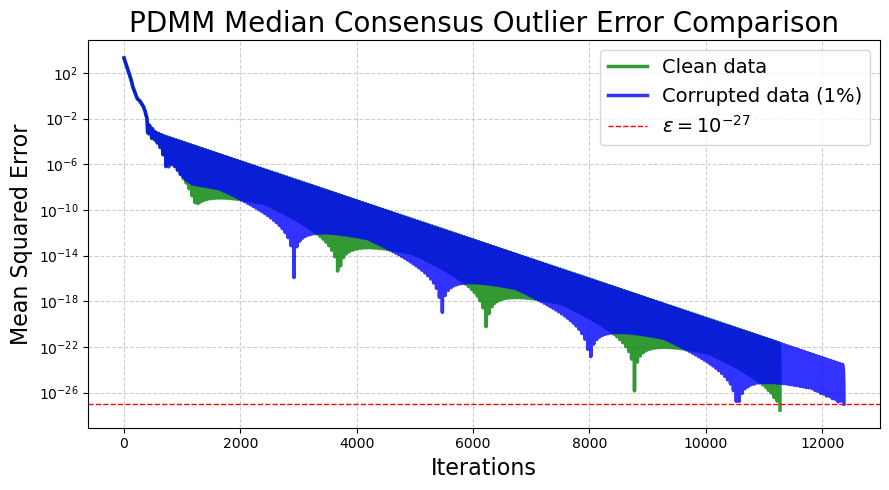

In [19]:
# Function to corrupt sensor values in different ways
def corrupt_sensor_values(sensor_values, percent_corrupted, corruption_type):

    corrupted = sensor_values.copy()
    n = len(sensor_values)
    num_corrupt = int(percent_corrupted * n)
    
    np.random.seed(50)
    indices = np.random.choice(n, num_corrupt, replace=False)

    if corruption_type == 'max':
        outlier_value = np.max(sensor_values)
    elif corruption_type == 'min':
        outlier_value = np.min(sensor_values)
    elif corruption_type == 'zero':
        outlier_value = 0
    elif corruption_type == 'random':
        outlier_value = np.random.uniform(np.min(sensor_values), np.max(sensor_values), size=1)[0]
    else:
        outlier_value = 0  # default to zero (broken sensor)

    corrupted[indices] = outlier_value
    return corrupted

# Set corruption percentage and type
percent_corrupted = 0.01
corruption_type = 'random'  # or 'zero'

# Generate corrupted sensor values
sensor_values_corrupted = corrupt_sensor_values(sensor_values.flatten(), percent_corrupted, corruption_type)
sensor_values_corrupted = sensor_values_corrupted.reshape(sensor_values.shape)

# Compute true average/median from CLEAN data
true_avg = np.mean(sensor_values)
true_med = np.median(sensor_values)

_, error_ac_corrupted, _ = pdmm_average_consensus(adj_matrix, sensor_values_corrupted, c=0.4, iters=2000, seed=50, verbose=False, trueAvg=true_avg)
_, error_mc_corrupted, _ = pdmm_median_consensus(adj_matrix, sensor_values_corrupted, c=0.1, iters=20000, seed=50, verbose=False, trueMed=true_med)

plt.figure(figsize=(9,5))
plt.semilogy(error_ac, color='orange', lw=2.5, alpha=0.8, label='Clean data')
plt.semilogy(
    error_ac_corrupted,
    color='blue',
    lw=2.5,
    alpha=0.8,
    label=f'Corrupted data ({int(percent_corrupted*100)}%)'
)
plt.axhline(
    1e-27, color='red', linestyle='--', linewidth=1, label=r'$\epsilon = 10^{-27}$'
)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Mean Squared Error", fontsize=16)
plt.title("PDMM Average Consensus Outlier Error Comparison", fontsize=20)
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,5))
plt.semilogy(error_mc, color='green', lw=2.5, alpha=0.8, label='Clean data')
plt.semilogy(
    error_mc_corrupted,
    color='blue',
    lw=2.5,
    alpha=0.8,
    label=f'Corrupted data ({int(percent_corrupted*100)}%)'
)
plt.axhline(
    1e-27, color='red', linestyle='--', linewidth=1, label=r'$\epsilon = 10^{-27}$'
)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Mean Squared Error", fontsize=16)
plt.title("PDMM Median Consensus Outlier Error Comparison", fontsize=20)
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

###
B. Hyperparameter Optimization with different values of 'c'

In [ ]:
# Find optimal c for Average Consensus

c_values = np.linspace(0.1, 1.5, 15)
errors_vs_c = []
final_errors = []

for c in c_values:
    x_hist, error_ac, elapsed = pdmm_average_consensus(adj_matrix, sensor_values, c=c, iters=2000, seed=50, verbose=False)
    errors_vs_c.append(error_ac)
    final_errors.append(error_ac[-1])

print('Ready for Plotting!')

Ready for Plotting!


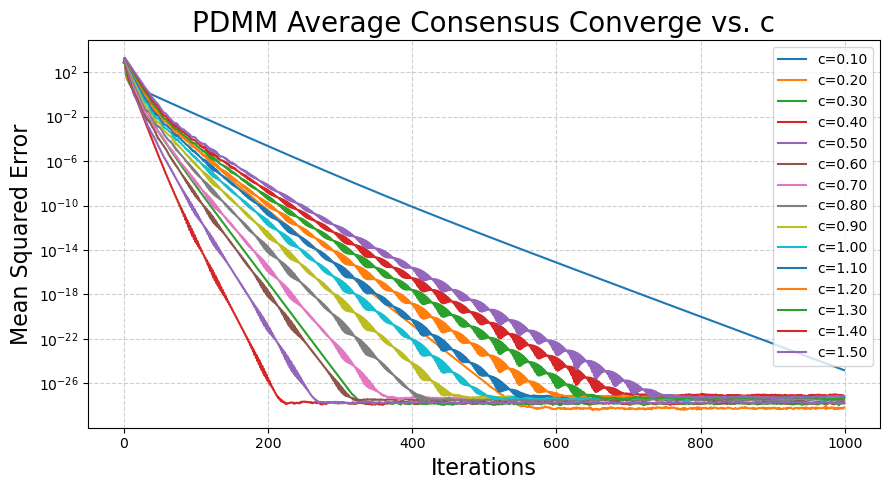

Best c is 0.100 with final error 3.16e-29


In [ ]:
# Plot convergence for different c (Average Consensus)
plt.figure(figsize=(9, 5))
for idx, c in enumerate(c_values):
    plt.semilogy(errors_vs_c[idx][:1000], label=f"c={c:.2f}")
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Mean Squared Error", fontsize=16)
plt.title("PDMM Average Consensus Converge vs. c", fontsize=20)
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# === Report best c
best_c_idx = np.argmin(final_errors)
print(f"Best c is {c_values[best_c_idx]:.3f} with final error {final_errors[best_c_idx]:.2e}")

In [ ]:
# Find optimal c for Average Consensus

c_values = np.linspace(0.1, 1.5, 10)
errors_vs_c = []
final_errors = []

for c in c_values:
    x_final, error_mc, elapsed = pdmm_median_consensus(adj_matrix, sensor_values, c=c, iters=20000, seed=50, verbose=False)
    errors_vs_c.append(error_mc)
    final_errors.append(error_mc[-1])

print('Ready for Plotting!')

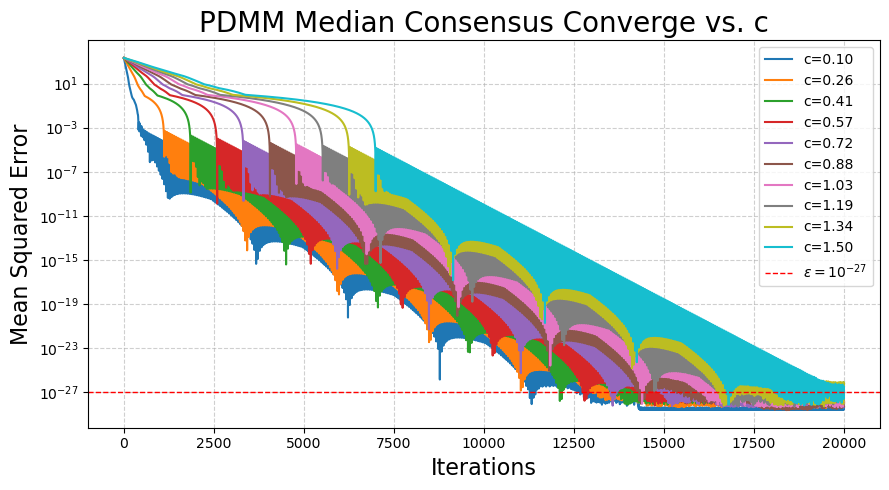

Best c is 0.100 with final error 3.82e-29


In [ ]:
# Plot convergence for different c (Median Consensus)
plt.figure(figsize=(9, 5))
for idx, c in enumerate(c_values):
    plt.semilogy(errors_vs_c[idx], label=f"c={c:.2f}")
plt.axhline(1e-27, color='red', linestyle='--', linewidth=1,
            label=r'$\epsilon = 10^{-27}$')
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Mean Squared Error", fontsize=16)
plt.title("PDMM Median Consensus Converge vs. c", fontsize=20)
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# === Report best c
best_c_idx = np.argmin(final_errors)
print(f"Best c is {c_values[best_c_idx]:.3f} with final error {final_errors[best_c_idx]:.2e}")


###
C. Comparing Convergence Rates across algorithms

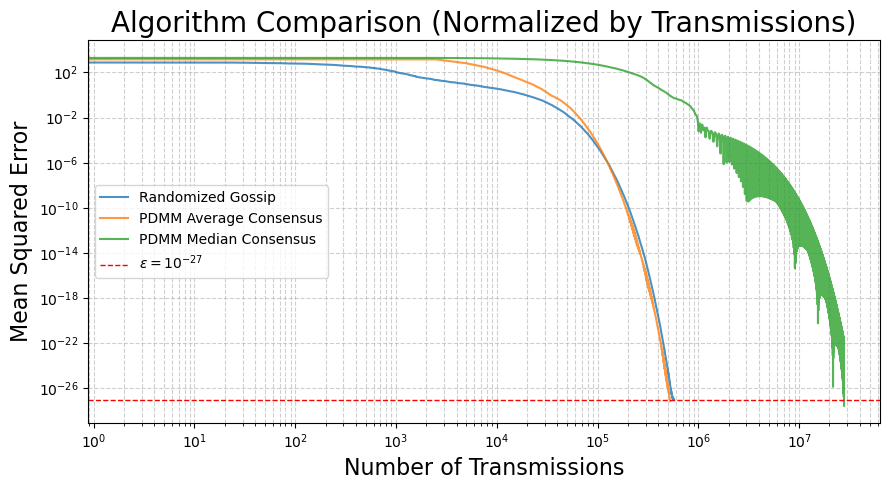

In [20]:
# Calculate the number of edges in the graph
num_edges = G.number_of_edges()

# Create the x-axis arrays for transmissions
transmissions_rg = np.arange(len(error_rg)) * 2  # 2 transmissions per gossip iteration
transmissions_pdmm_ac = np.arange(len(error_ac)) * (2 * num_edges) # 2*|E| transmissions per PDMM iteration
transmissions_pdmm_mc = np.arange(len(error_mc)) * (2 * num_edges)

plt.figure(figsize=(9,5))

# Plot error vs. number of transmissions
plt.loglog(transmissions_rg, error_rg, label='Randomized Gossip', alpha=0.8)
plt.loglog(transmissions_pdmm_ac, error_ac, label='PDMM Average Consensus', alpha=0.8)
plt.loglog(transmissions_pdmm_mc, error_mc, label='PDMM Median Consensus', alpha=0.8)

plt.axhline(1e-27, color='red', linestyle='--', linewidth=1, label=r'$\epsilon = 10^{-27}$')
plt.xlabel("Number of Transmissions", fontsize=16)
plt.ylabel("Mean Squared Error", fontsize=16)
plt.title('Algorithm Comparison (Normalized by Transmissions)', fontsize=20)
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

###
D. Transmission Failures


In [ ]:
failure_rates = [0, 0.005, 0.01, 0.05, 0.10, 0.25, 0.5]
color_cycle = plt.cm.viridis(np.linspace(0, 1, len(failure_rates)))
num_edges = np.sum(adj_matrix) // 2  # Number of edges

# --- 1. Randomized Gossip ---
gossip_errors = []
gossip_transmissions = []
for pf in failure_rates:
    errors, elapsed = randomized_gossip_average_consensus(
        adj_matrix,
        sensor_values,
        iters=1000000,
        p_fail=pf,
        seed=50,
        verbose=False
    )
    gossip_errors.append(errors)
    # 2 transmissions per iteration (1 per node in edge)
    gossip_transmissions.append(np.arange(1, len(errors)+1) * 2)

# --- 2. PDMM Average Consensus ---
pdmm_avg_errors = []
pdmm_avg_transmissions = []
for pf in failure_rates:
    x_hist, errors, elapsed = pdmm_average_consensus(
        adj_matrix,
        sensor_values,
        c=0.4,
        iters=500,
        p_fail=pf,
        seed=50,
        verbose=False
    )
    pdmm_avg_errors.append(errors)
    # 2*|E| transmissions per iteration
    pdmm_avg_transmissions.append(np.arange(1, len(errors)+1) * (2 * num_edges))

# --- 3. PDMM Median Consensus ---
pdmm_median_errors = []
pdmm_median_transmissions = []
for pf in failure_rates:
    x_final, errors, elapsed = pdmm_median_consensus(
        adj_matrix,
        sensor_values,
        c=0.1,
        iters=20000,
        p_fail=pf,
        seed=50,
        verbose=False
    )
    pdmm_median_errors.append(errors)
    # 2*|E| transmissions per iteration
    pdmm_median_transmissions.append(np.arange(1, len(errors)+1) * (2 * num_edges))

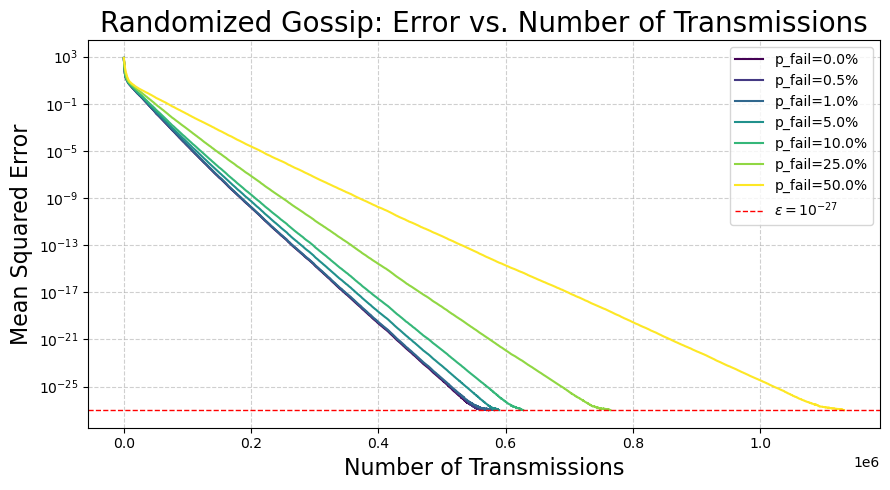

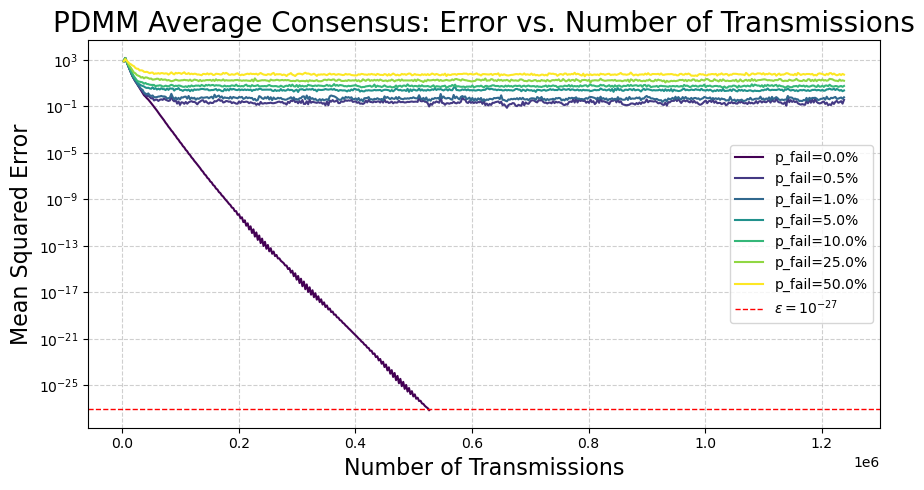

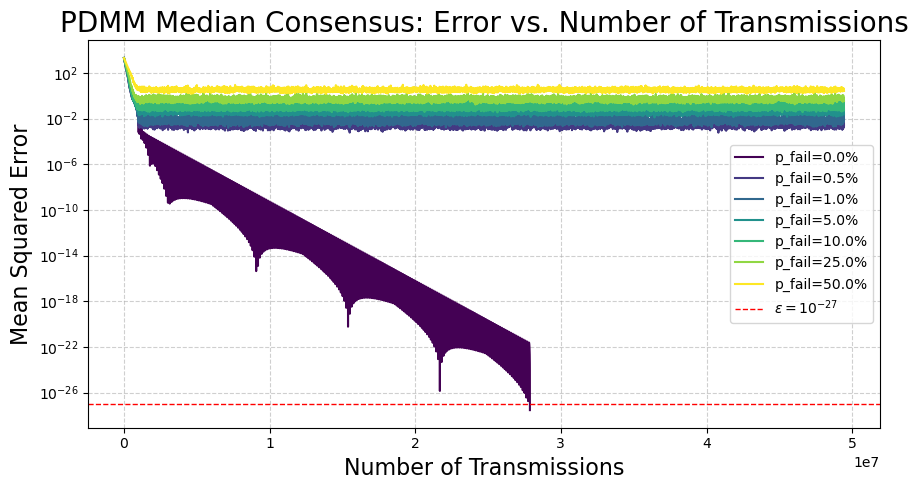

In [ ]:
plt.figure(figsize=(9, 5))
for idx, pf in enumerate(failure_rates):
    plt.semilogy(gossip_transmissions[idx], gossip_errors[idx], label=f"p_fail={100*pf:.1f}%", color=color_cycle[idx])
plt.axhline(1e-27, color='red', linestyle='--', linewidth=1, label=r'$\epsilon = 10^{-27}$')
plt.xlabel("Number of Transmissions", fontsize=16)
plt.ylabel("Mean Squared Error", fontsize=16)
plt.title("Randomized Gossip: Error vs. Number of Transmissions", fontsize=20)
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))
for idx, pf in enumerate(failure_rates):
    plt.semilogy(pdmm_avg_transmissions[idx], pdmm_avg_errors[idx], label=f"p_fail={100*pf:.1f}%", color=color_cycle[idx])
plt.axhline(1e-27, color='red', linestyle='--', linewidth=1, label=r'$\epsilon = 10^{-27}$')
plt.xlabel("Number of Transmissions", fontsize=16)
plt.ylabel("Mean Squared Error", fontsize=16)
plt.title("PDMM Average Consensus: Error vs. Number of Transmissions", fontsize=20)
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))
for idx, pf in enumerate(failure_rates):
    plt.semilogy(pdmm_median_transmissions[idx], pdmm_median_errors[idx], label=f"p_fail={100*pf:.1f}%", color=color_cycle[idx])
plt.axhline(1e-27, color='red', linestyle='--', linewidth=1, label=r'$\epsilon = 10^{-27}$')
plt.xlabel("Number of Transmissions", fontsize=16)
plt.ylabel("Mean Squared Error", fontsize=16)
plt.title("PDMM Median Consensus: Error vs. Number of Transmissions", fontsize=20)
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
